### BABI4005 
#### Scraping and Unstructured Data

### Course Map Project

#### Project Goal:
##### Scrape all BABI course pages from the BCIT website, extract prerequisite information, and later build a prerequisite network graph with pathway analysis.

#### STEP 1: Load the BABI Subject Page

This page lists all Business Analytics (BABI) courses.
It will serve as our starting point ("seed page").

From this page, we will extract links to each individual BABI course page.

#### 1. Import Required Libraries

Required libraries for HTTP requests and HTML parsing

In [1]:
import requests
from bs4 import BeautifulSoup

#### 2. Define the Base URL for Course Search

This page serves as the seed source for extracting all BABI course URLs.

In [2]:
courses_page_url = "https://www.bcit.ca/course_subjects/business-analytics-business-intelligence-babi/"

#### 3. Send HTTP Request to Retrieve Page

Retrieve the subject page HTML for parsing.

In [3]:
response = requests.get(courses_page_url)

#### 4. Check Status Code
A status code of 200 means the request succeeded.

In [4]:
print("Status Code:", response.status_code)

Status Code: 200


#### 5. Parse HTML with BeautifulSoup

We use the "lxml" parser because it is fast and robust.

In [5]:
soup = BeautifulSoup(response.text, "lxml")

#### 6. Preview a Small Portion of the HTML

This allows us to visually confirm that we successfully retrieved the webpage content.

In [6]:
print(soup.prettify()[:500])

<!DOCTYPE html>
<html lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <meta content="BCIT" name="author"/>
  <meta content="True" name="HandheldFriendly"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <meta content="Course Subject: &lt;span&gt;Business Analytics &amp; Business Intelligence — BABI&lt;/span&gt;" name="apple-mobile-web-app-title"/>
  <meta content="BCIT" name="application-name"/>
  <meta content="Home" name="section"/>
  <script>
   var modern_tribe


#### STEP 2: Extract and Clean BABI Course URLs

This step isolates valid BABI course pages from the subject listing.

Filtering criteria:
- URL must contain `/courses/`
- URL must include `babi` (case insensitive)

The resulting list represents the structured seed dataset for downstream scraping.

#### 1. Collect all anchor tags from the page

In [7]:
all_links = soup.find_all("a")

course_links = []

for link in all_links:
    href = link.get("href")
    
    # Ensure href exists and matches our course pattern
    if href and "/courses/" in href and "babi" in href.lower():
        course_links.append(href)

#### 2. Remove duplicates

In [8]:
course_links = list(set(course_links))

#### 3. Sort alphabetically for clean output

In [9]:
course_links.sort()

#### 4. Dataset Validation: Extracted BABI Course Links

Verify that the extracted URLs:
- Represent valid BABI course pages  
- Contain no duplicates  
- Are correctly formatted  

This ensures data integrity before downstream parsing.

In [10]:
print("Number of BABI course links found:", len(course_links))
print("\nSample links:")
for link in course_links[:5]:
    print(link)

Number of BABI course links found: 12

Sample links:
https://www.bcit.ca/courses/analytic-models-for-business-decisions-babi-2500/
https://www.bcit.ca/courses/applied-data-management-for-analytics-babi-4000/
https://www.bcit.ca/courses/business-analytics-fundamentals-babi-4100/
https://www.bcit.ca/courses/business-analytics-theory-babi-3100/
https://www.bcit.ca/courses/capstone-business-analytics-project-babi-3500/


#### STEP 3: Test Scraping an Individual Course Page

We will select one course URL from our extracted list and inspect its structure.

#### 1. Select first course link for testing

In [11]:
test_course_url = course_links[0]

print("Testing URL:", test_course_url)

Testing URL: https://www.bcit.ca/courses/analytic-models-for-business-decisions-babi-2500/


#### 2. Send request

In [12]:
course_response = requests.get(test_course_url)

print("Status Code:", course_response.status_code)

Status Code: 200


#### Parse HTML

In [13]:
course_soup = BeautifulSoup(course_response.text, "lxml")

#### 3. Preview part of page

In [14]:
print(course_soup.prettify()[:800])

<!DOCTYPE html>
<html lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <meta content="nofollow,noindex" name="robots"/>
  <meta content="BCIT" name="author"/>
  <meta content="BABI,2500,BABI2500,Analytic Models for Business Decisions" name="keywords"/>
  <meta content="Students will access a dataset, analyze it using quantitative methods, select and format the data and explore to discover trends and correlations to answer specific business questions. This course will bridge the gap between the technical and business requirements of business analytics by building models for key business areas. Such models will be based on value added KPI’s reflecting stakeholder’s needs and the level of needs within the organizational hierarchy: executive, management, operational. Students will learn to as


#### 4. Search for the word "Prerequisite" inside the page text

In [15]:
if "Prerequisite" in course_soup.text:
    print("Prerequisite section exists on this page.")
else:
    print("No prerequisite section found.")

Prerequisite section exists on this page.


#### STEP 4: Locate the Prerequisite Section in HTML

We search for HTML elements that contain the word"Prerequisite" so we can inspect their structure.

In [16]:
for tag in course_soup.find_all():
    if tag.string and "Prerequisite" in tag.string:
        print("Tag found:", tag.name)
        print("Content:", tag.string)
        print("-" * 50)

Tag found: script
Content: 
			{"@context":"https:\/\/schema.org","@type":"Course","name":"Analytic Models for Business Decisions","courseCode":"BABI 2500","description":"Students will access a dataset, analyze it using quantitative methods, select and format the data and explore to discover trends and correlations to answer specific business questions. This course will bridge the gap between the technical and business requirements of business analytics by building models for key business areas. Such models will be based on value added KPI\u2019s reflecting stakeholder\u2019s needs and the level of needs within the organizational hierarchy: executive, management, operational. Students will learn to ask the right questions to solve the real business issues.","provider":{"@type":"EducationalOrganization","name":"British Columbia Institute of Technology","department":{"@type":"Organization","name":"School of Business + Media"},"address":{"@type":"PostalAddress","streetAddress":"3700 Willi

#### STEP 5: Extract Prerequisite Text

Strategy:
1. Locate the h3 tag containing "Prerequisite"
2. Get the next element (which should contain the actual text)

In [17]:
prereq_text = None

# Find all h3 tags
for header in course_soup.find_all("h3"):
    if "Prerequisite" in header.text:
        # Get the next HTML element after the header
        next_element = header.find_next_sibling()
        
        if next_element:
            prereq_text = next_element.get_text(strip=True)
        break


print("Extracted Prerequisite Text:")
print(prereq_text)

Extracted Prerequisite Text:



#### STEP 6: Extract Prerequisites from JSON-LD Script

Many modern websites embed structured course data inside script type="application/ld+json" tags.

We will locate that script and parse the JSON.


In [18]:
import json

prereq_text = None

# Find all script tags
for script in course_soup.find_all("script", type="application/ld+json"):
    try:
        data = json.loads(script.string)
        
        if "coursePrerequisites" in data:
            prereq_text = data["coursePrerequisites"]
            break
            
    except:
        continue

print("Extracted Prerequisite Text:")
print(prereq_text)

Extracted Prerequisite Text:
BABI 1100 and BABI 1600 and BABI 2200


#### STEP 7: Parse Structured Course Codes from Text
Convert the prerequisite string into a clean list of standardized course codes (e.g., BABI1100).

In [19]:
import re

parsed_prereqs = []

if prereq_text:
    # Match patterns like "BABI 1100"
    pattern = r"BABI\s?\d{4}"
    matches = re.findall(pattern, prereq_text)

    # Remove spaces for clean formatting
    parsed_prereqs = [code.replace(" ", "") for code in matches]

print("Parsed Prerequisite Course Codes:")
print(parsed_prereqs)

Parsed Prerequisite Course Codes:
['BABI1100', 'BABI1600', 'BABI2200']


#### STEP 8: Create Function to Extract Prerequisites from Any Course URL

This function:
1. Downloads a course page
2. Extracts prerequisite text from JSON-LD
3. Parses structured course codes
4. Returns a clean list

In [20]:
import requests
import json
import re
from bs4 import BeautifulSoup


def extract_prerequisites(course_url):
    response = requests.get(course_url)
    soup = BeautifulSoup(response.text, "lxml")

    prereq_text = None

    # Extract JSON-LD metadata
    for script in soup.find_all("script", type="application/ld+json"):
        try:
            data = json.loads(script.string)

            if "coursePrerequisites" in data:
                prereq_text = data["coursePrerequisites"]
                break
        except:
            continue

    # Parse structured codes
    parsed_prereqs = []

    if prereq_text:
        pattern = r"BABI\s?\d{4}"
        matches = re.findall(pattern, prereq_text)
        parsed_prereqs = [code.replace(" ", "") for code in matches]

    return parsed_prereqs

In [21]:
# Test function on first course
test_result = extract_prerequisites(course_links[0])

print("Course:", course_links[0])
print("Prerequisites:", test_result)

Course: https://www.bcit.ca/courses/analytic-models-for-business-decisions-babi-2500/
Prerequisites: ['BABI1100', 'BABI1600', 'BABI2200']


#### STEP 9: Extract Prerequisites for All BABI Courses

Loop through all extracted course URLs and build a structured dictionary mapping:

Course: List of prerequisite course codes

In [22]:
course_prereq_map = {}

for url in course_links:
    
    # Extract course code from URL
    # Example: "...-babi-2500/" -> BABI2500
    course_code_match = re.search(r"BABI-\d{4}", url.upper())
    
    if course_code_match:
        course_code = course_code_match.group().replace("-", "")
    else:
        continue
    
    prereqs = extract_prerequisites(url)
    
    course_prereq_map[course_code] = prereqs

In [23]:
# Preview result
for course, prereqs in course_prereq_map.items():
    print(course, "->", prereqs)

BABI2500 -> ['BABI1100', 'BABI1600', 'BABI2200']
BABI4000 -> ['BABI3000']
BABI4100 -> []
BABI3100 -> []
BABI3500 -> ['BABI1100', 'BABI1600', 'BABI2200', 'BABI2500']
BABI3005 -> []
BABI3000 -> []
BABI2700 -> ['BABI2500']
BABI4005 -> ['BABI3005']
BABI2200 -> ['BABI1100']
BABI9005 -> []
BABI1600 -> []


#### STEP 10: Build Prerequisite Network Graph

We create a directed graph where:
Prerequisite = Course

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes and edges
for course, prereqs in course_prereq_map.items():
    G.add_node(course)
    
    for prereq in prereqs:
        G.add_edge(prereq, course)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 13
Number of edges: 11


#### STEP 11: Visualize the Prerequisite Network

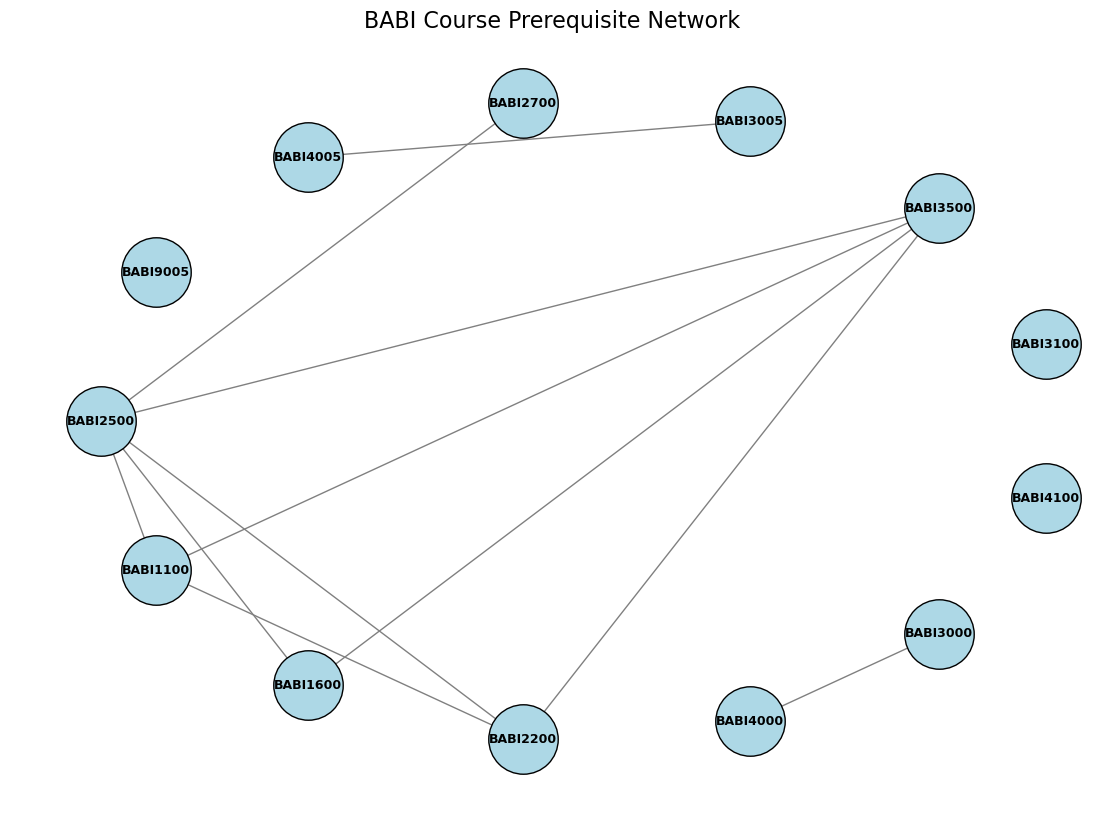

In [25]:
plt.figure(figsize=(14, 10))

# Try shell layout (often cleaner for small networks)
pos = nx.shell_layout(G)

nx.draw_networkx_nodes(
    G,
    pos,
    node_size=2500,
    node_color="lightblue",
    edgecolors="black"
)

nx.draw_networkx_edges(
    G,
    pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=15,
    edge_color="gray"
)

nx.draw_networkx_labels(
    G,
    pos,
    font_size=9,
    font_weight="bold"
)

plt.title("BABI Course Prerequisite Network", fontsize=16)
plt.axis("off")
plt.show()

This graph shows how the BABI courses connect through prerequisites. The courses move from left to right based on how advanced they are, with foundational courses on the left and more advanced ones on the right. The arrows show which courses you need to take before others, so you can clearly see the learning progression through the program.

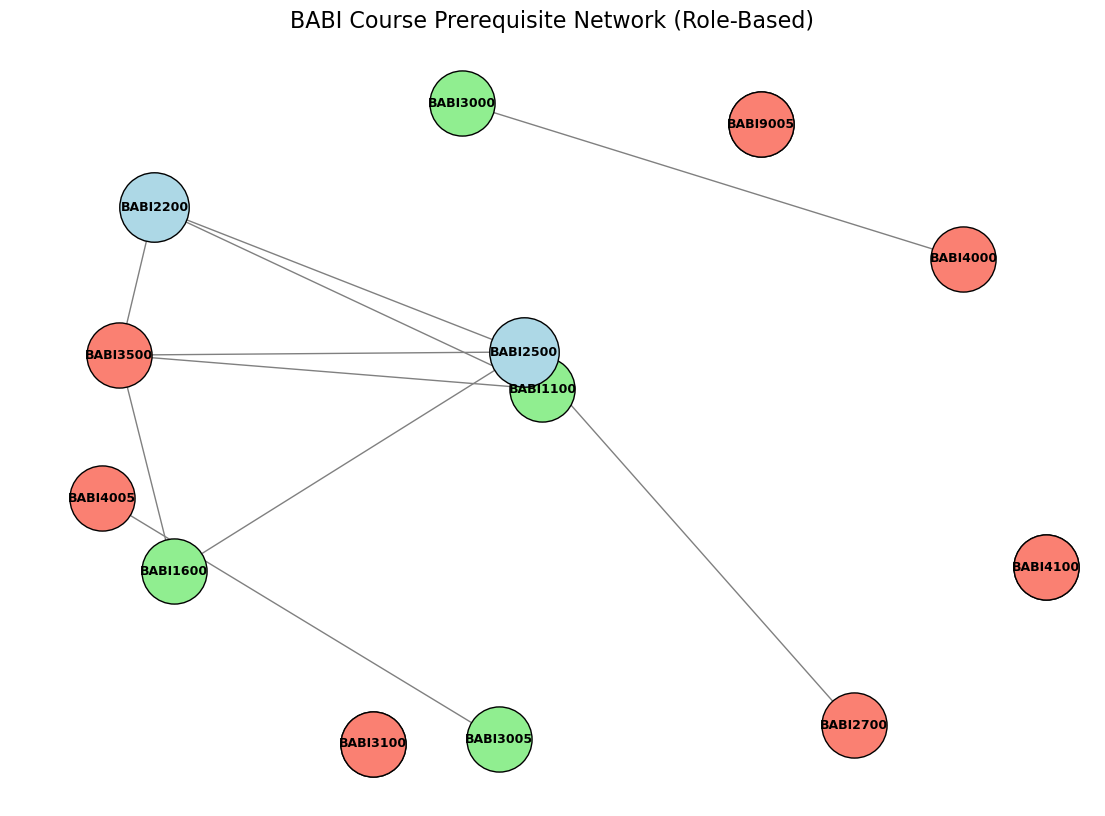

In [26]:
plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G, k=1.3, seed=42)

# Identify entry-level courses (no incoming edges)
entry_courses = [node for node in G.nodes() if G.in_degree(node) == 0]

# Identify advanced courses (no outgoing edges)
advanced_courses = [node for node in G.nodes() if G.out_degree(node) == 0]

# Identify intermediate courses
intermediate_courses = [
    node for node in G.nodes()
    if node not in entry_courses and node not in advanced_courses
]

# Draw entry-level (green)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=entry_courses,
    node_color="lightgreen",
    node_size=2200,
    edgecolors="black"
)

# Draw intermediate (lightblue)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=intermediate_courses,
    node_color="lightblue",
    node_size=2500,
    edgecolors="black"
)

# Draw advanced (salmon)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=advanced_courses,
    node_color="salmon",
    node_size=2200,
    edgecolors="black"
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=15,
    edge_color="gray"
)

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    font_size=9,
    font_weight="bold"
)

plt.title("BABI Course Prerequisite Network (Role-Based)", fontsize=16)
plt.axis("off")
plt.show()

This version groups the courses by their role in the program. Green courses don’t have prerequisites, blue ones are in the middle of the pathway, and red ones are more advanced or final-level courses. This makes it easier to see how different courses function within the overall structure, not just the order they’re taken.

#### STEP 12: Centrality & Pathway Analysis

In this section, we analyze the prerequisite network using graph metrics.  
This allows us to move beyond visualization and identify structurally important courses within the program.

We will compute:
- In-degree (number of prerequisites required)
- Out-degree (number of courses unlocked)
- Betweenness centrality (network bottleneck importance)
- Entry-level course detection

#### 1. Compute Centrality Metrics

In [27]:
# --- In-degree (prerequisites required) ---
in_degree = dict(G.in_degree())

# --- Out-degree (courses unlocked) ---
out_degree = dict(G.out_degree())

# --- Betweenness centrality (structural importance) ---
betweenness = nx.betweenness_centrality(G)

# Preview metrics for first few courses
for course in list(G.nodes())[:5]:
    print(f"{course}")
    print("  Prerequisites Required:", in_degree[course])
    print("  Courses Unlocked:", out_degree[course])
    print("  Betweenness:", round(betweenness[course], 3))
    print("-" * 40)

BABI2500
  Prerequisites Required: 3
  Courses Unlocked: 2
  Betweenness: 0.023
----------------------------------------
BABI1100
  Prerequisites Required: 0
  Courses Unlocked: 3
  Betweenness: 0.0
----------------------------------------
BABI1600
  Prerequisites Required: 0
  Courses Unlocked: 2
  Betweenness: 0.0
----------------------------------------
BABI2200
  Prerequisites Required: 1
  Courses Unlocked: 2
  Betweenness: 0.0
----------------------------------------
BABI4000
  Prerequisites Required: 1
  Courses Unlocked: 0
  Betweenness: 0.0
----------------------------------------


In [28]:
# STEP 13: Identify Key Structural Courses
# ============================================================

# Course requiring the most prerequisites
most_prereqs = max(in_degree, key=in_degree.get)

# Course unlocking the most others
most_unlocks = max(out_degree, key=out_degree.get)

# Most central course (highest betweenness)
most_central = max(betweenness, key=betweenness.get)

# Entry-level courses (no prerequisites)
entry_courses = [node for node in G.nodes() if in_degree[node] == 0]

print("Course requiring the most prerequisites:")
print(most_prereqs, "->", in_degree[most_prereqs])

print("\nCourse unlocking the most others:")
print(most_unlocks, "->", out_degree[most_unlocks])

print("\nMost central course (betweenness):")
print(most_central, "->", round(betweenness[most_central], 3))

print("\nEntry-level courses:")
print(entry_courses)

Course requiring the most prerequisites:
BABI3500 -> 4

Course unlocking the most others:
BABI1100 -> 3

Most central course (betweenness):
BABI2500 -> 0.023

Entry-level courses:
['BABI1100', 'BABI1600', 'BABI3000', 'BABI4100', 'BABI3100', 'BABI3005', 'BABI9005']


#### 2.Identify Key Structural Courses

In [29]:
# Course requiring the most prerequisites
most_prereqs = max(in_degree, key=in_degree.get)

# Course unlocking the most others
most_unlocks = max(out_degree, key=out_degree.get)

# Most central course (highest betweenness)
most_central = max(betweenness, key=betweenness.get)

# Entry-level courses (no prerequisites)
entry_courses = [node for node in G.nodes() if in_degree[node] == 0]

print("Course requiring the most prerequisites:")
print(most_prereqs, "->", in_degree[most_prereqs])

print("\nCourse unlocking the most others:")
print(most_unlocks, "->", out_degree[most_unlocks])

print("\nMost central course (betweenness):")
print(most_central, "->", round(betweenness[most_central], 3))

print("\nEntry-level courses:")
print(entry_courses)

Course requiring the most prerequisites:
BABI3500 -> 4

Course unlocking the most others:
BABI1100 -> 3

Most central course (betweenness):
BABI2500 -> 0.023

Entry-level courses:
['BABI1100', 'BABI1600', 'BABI3000', 'BABI4100', 'BABI3100', 'BABI3005', 'BABI9005']


#### Interpretation

The analysis shows that BABI3500 has the most prerequisites (4), making it the most knowledge-intensive course in the program. This suggests it sits later in the curriculum and builds on multiple earlier courses.

BABI1100 unlocks most other courses (3), meaning it functions as an important foundational course that enables progression through the program.

Based on betweenness centrality, BABI2500 appears to be the most structurally central course in the network. Although its numerical score is modest (0.023), it acts as a key connector between foundational and more advanced courses.

The identified entry-level courses (BABI1100, BABI1600, BABI3000, BABI4100, BABI3100, BABI3005, and BABI9005) have no prerequisites, meaning students can begin the program from multiple starting points depending on their pathway.

#### STEP 14: Export Structured Data to CSV

In this section, we export the structured prerequisite data and computed network metrics to CSV files.

This allows the results of the scraping and network analysis to be reused, shared, or analyzed further outside of Python.

In [30]:
import pandas as pd

# Create list to store prerequisite relationships
edges = []

# Loop through graph edges
# Each edge is (prerequisite -> course)
for prereq, course in G.edges():
    edges.append({
        "Prerequisite": prereq,
        "Course": course
    })

# Convert to DataFrame
df_edges = pd.DataFrame(edges)

# Export to CSV
df_edges.to_csv("babi_prerequisite_edges.csv", index=False)

# Preview
df_edges.head()

,Prerequisite,Course
0,BABI2500,BABI3500
1,BABI2500,BABI2700
2,BABI1100,BABI2500
3,BABI1100,BABI3500
4,BABI1100,BABI2200


#### STEP 14B: Export Course-Level Network Metrics

We create a summary table containing:

- Number of prerequisites required (in-degree)
- Number of courses unlocked (out-degree)
- Betweenness centrality (structural importance)
- Entry-level flag (True if no prerequisites)

 This provides a structured analytical dataset.

In [31]:
course_data = []

# Loop through each course in the graph
for node in G.nodes():
    course_data.append({
        "Course": node,
        "Num_Prerequisites": in_degree[node],
        "Unlocks_Others": out_degree[node],
        "Betweenness": round(betweenness[node], 4),
        "Entry_Level": in_degree[node] == 0
    })

# Convert to DataFrame
df_courses = pd.DataFrame(course_data)

# Export to CSV
df_courses.to_csv("babi_course_metrics.csv", index=False)

# Preview
df_courses.head()

,Course,Num_Prerequisites,Unlocks_Others,Betweenness,Entry_Level
0,BABI2500,3,2,0.0227,False
1,BABI1100,0,3,0.0000,True
2,BABI1600,0,2,0.0000,True
3,BABI2200,1,2,0.0000,False
4,BABI4000,1,0,0.0000,False
